In [2]:
# %%
import os
import ast
import json
import pickle
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score

plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid")


In [3]:
# %%
RAW_DATA_PATH = "data/dataset.csv"
SYMPTOM_SEVERITY_PATH = "data/Symptom-severity.csv"
SYMPTOM_DESC_PATH = "data/symptom_Description.csv"
SYMPTOM_PRECAUTION_PATH = "data/symptom_precaution.csv"
PROCESSED_DIR = "data/processed"

os.makedirs(PROCESSED_DIR, exist_ok=True)

# Load main dataset
df = pd.read_csv(RAW_DATA_PATH)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Normalize strings
for col in df.columns:
    df[col] = df[col].astype(str).str.replace('_', ' ').str.strip()

# Fill NaNs
df = df.replace({"nan": np.nan}).fillna(0)
df.head()


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Acne,skin rash,blackheads,scurring,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Acne,skin rash,pus filled pimples,blackheads,scurring,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Hyperthyroidism,fatigue,mood swings,weight loss,restlessness,sweating,diarrhoea,fast heart rate,excessive hunger,muscle weakness,irritability,abnormal menstruation,0,0,0,0,0,0
3,AIDS,muscle wasting,patches in throat,high fever,extra marital contacts,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Chronic cholestasis,itching,vomiting,yellowish skin,nausea,loss of appetite,abdominal pain,yellowing of eyes,0,0,0,0,0,0,0,0,0,0


In [4]:
# %%
FEATURES_PATH = "features.pkl"

# Always create MODEL_SYMPTOMS from Symptom-severity.csv
df_severity = pd.read_csv(SYMPTOM_SEVERITY_PATH)
df_severity['Symptom'] = df_severity['Symptom'].astype(str).str.replace('_',' ').str.strip()
MODEL_SYMPTOMS = df_severity['Symptom'].dropna().unique().tolist()

# Save to pkl
with open(FEATURES_PATH,"wb") as f:
    pickle.dump(MODEL_SYMPTOMS,f)

print("Number of model symptoms:", len(MODEL_SYMPTOMS))
print("Sample symptoms:", MODEL_SYMPTOMS[:20])


Number of model symptoms: 132
Sample symptoms: ['itching', 'skin rash', 'nodal skin eruptions', 'continuous sneezing', 'shivering', 'chills', 'joint pain', 'stomach pain', 'acidity', 'ulcers on tongue', 'muscle wasting', 'vomiting', 'burning micturition', 'spotting urination', 'fatigue', 'weight gain', 'anxiety', 'cold hands and feets', 'mood swings', 'weight loss']


In [5]:
# %%
n_samples = df.shape[0]
n_features = len(MODEL_SYMPTOMS)
symptom_to_idx = {s: idx for idx, s in enumerate(MODEL_SYMPTOMS)}

data_cols = [c for c in df.columns if c.lower() != 'disease']
symptom_matrix = np.zeros((n_samples, n_features), dtype=np.int8)

for i, row in df.iterrows():
    for c in data_cols:
        val = row[c]
        if val and val != 0 and val in symptom_to_idx:
            symptom_matrix[i, symptom_to_idx[val]] = 1

dfx = pd.DataFrame(symptom_matrix, columns=MODEL_SYMPTOMS)
dfx.insert(0,"Disease",df['Disease'].astype(str).values)
dfx.to_csv(os.path.join(PROCESSED_DIR,"hotcoded_data.csv"), index=False)
dfx.head()


,Disease,itching,skin rash,nodal skin eruptions,continuous sneezing,shivering,chills,joint pain,stomach pain,acidity,...,blackheads,scurring,skin peeling,silver like dusting,small dents in nails,inflammatory nails,blister,red sore around nose,yellow crust ooze,prognosis
0,Acne,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,Acne,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,Hyperthyroidism,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AIDS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Chronic cholestasis,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


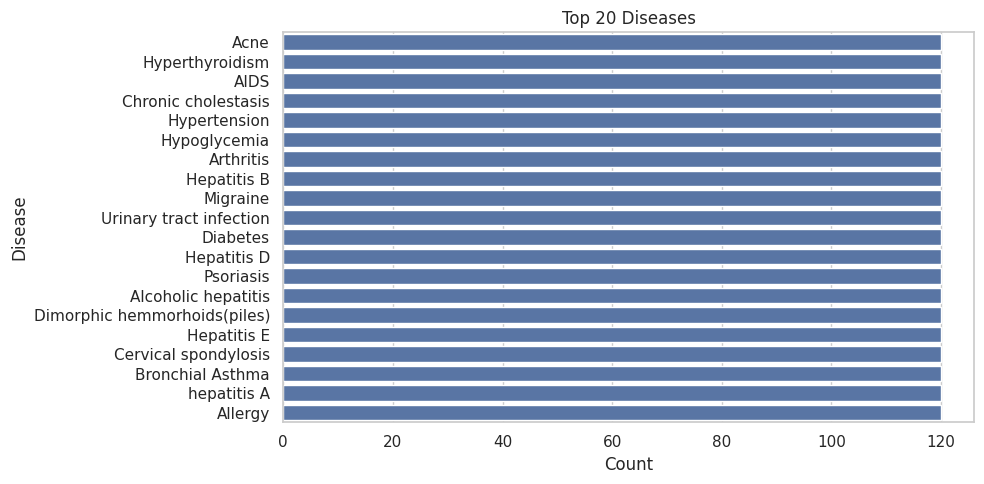

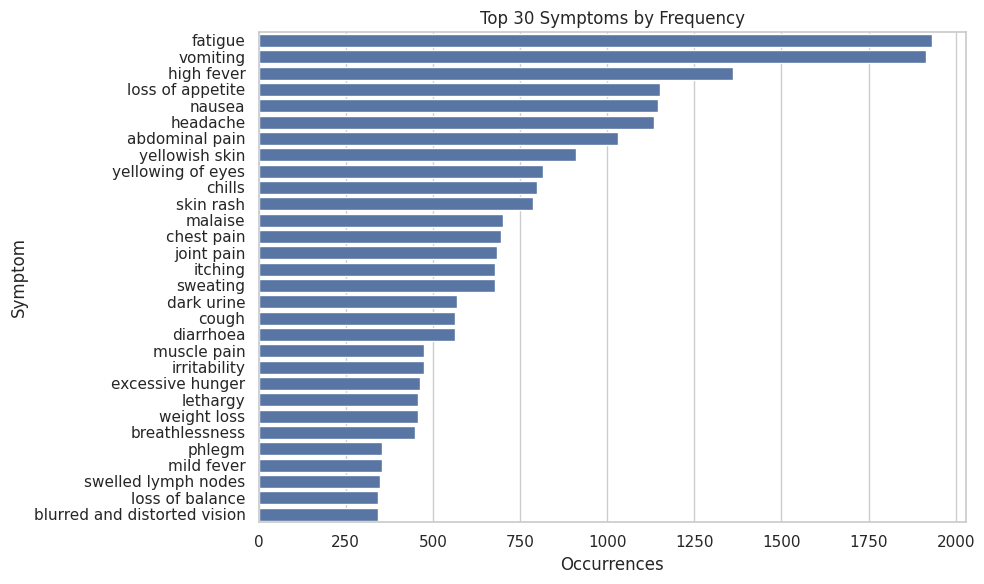

In [6]:
# %%
# Top 20 diseases
plt.figure(figsize=(10,5))
dcount = dfx['Disease'].value_counts()
sns.barplot(x=dcount.values[:20], y=dcount.index[:20])
plt.title("Top 20 Diseases")
plt.xlabel("Count")
plt.ylabel("Disease")
plt.tight_layout()
plt.show()

# Top 30 symptoms
symptom_freq = dfx.iloc[:,1:].sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=symptom_freq.values[:30], y=symptom_freq.index[:30])
plt.title("Top 30 Symptoms by Frequency")
plt.xlabel("Occurrences")
plt.ylabel("Symptom")
plt.tight_layout()
plt.show()


In [7]:
# %%
X = dfx.iloc[:,1:].values
y = dfx['Disease'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1765, stratify=y_train, random_state=42)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

print("Train/Val/Test shapes:", x_train.shape, x_val.shape, x_test.shape)
print("Number of classes:", len(le.classes_))


Train/Val/Test shapes: (2836, 132) (608, 132) (1476, 132)
Number of classes: 41


In [8]:
# %%
model = ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, x_train, y_train_enc, cv=kfold, scoring='f1_weighted', n_jobs=-1)
print("CV weighted-F1 (5-fold):", cv_scores.mean())

model.fit(x_train, y_train_enc)

y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)
print("Validation F1:", f1_score(y_val_enc, y_val_pred, average='weighted'))
print("Test F1:", f1_score(y_test_enc, y_test_pred, average='weighted'))


CV weighted-F1 (5-fold): 1.0
Validation F1: 1.0
Test F1: 1.0


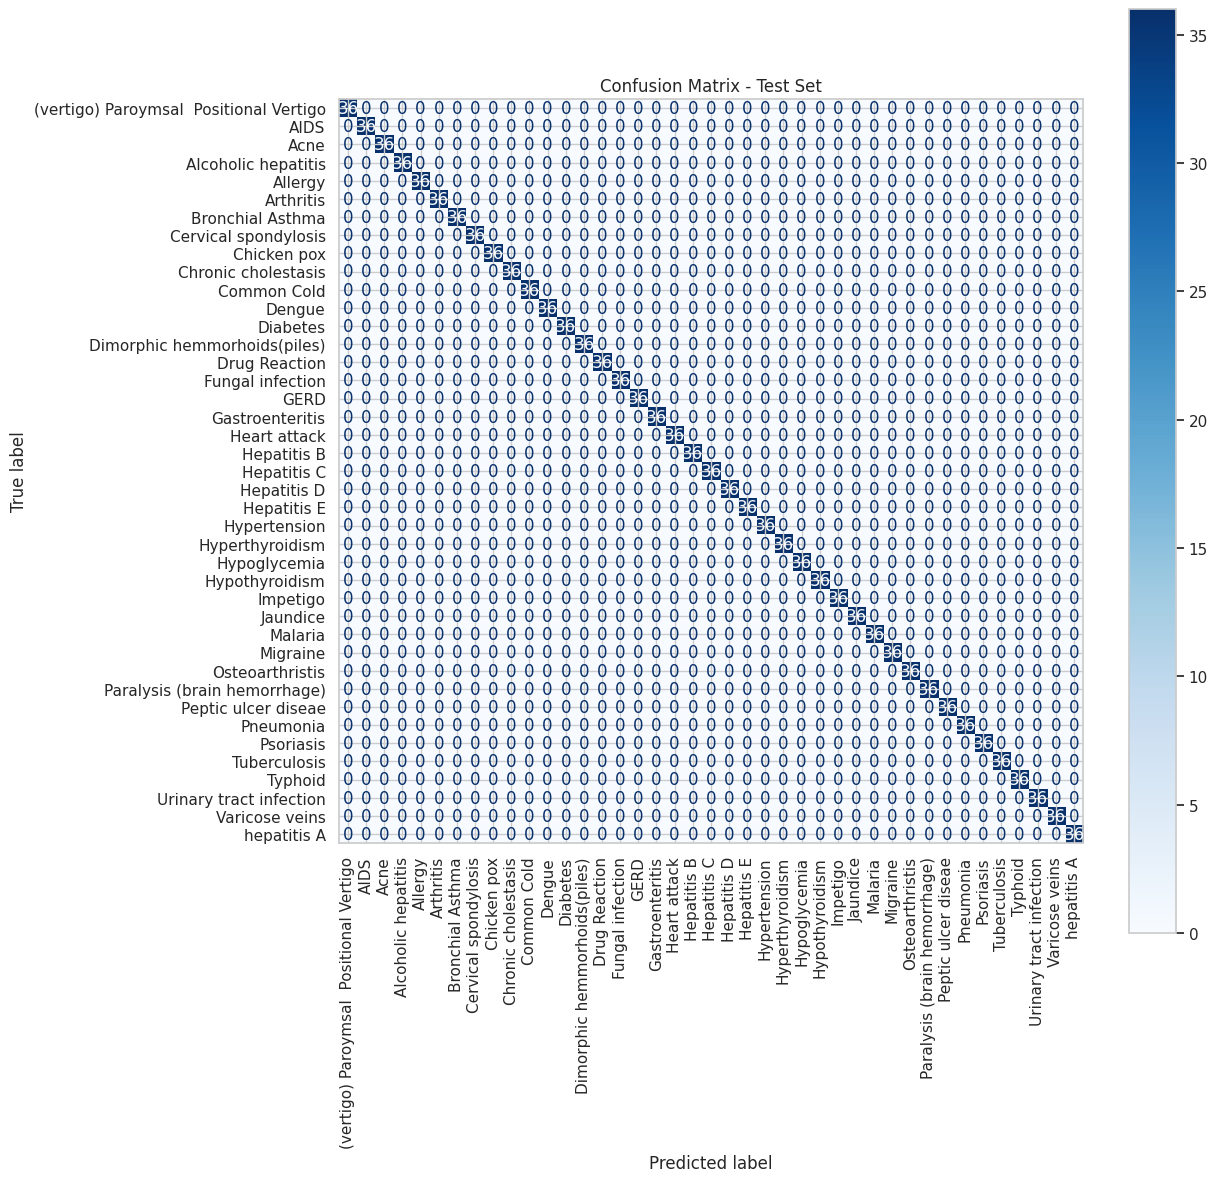

In [56]:
# %%
from sklearn.metrics import ConfusionMatrixDisplay

# Predict on test set
y_test_pred = model.predict(x_test)

# Display confusion matrix
cm = confusion_matrix(y_test_enc, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=90)
plt.title("Confusion Matrix - Test Set")
plt.show()


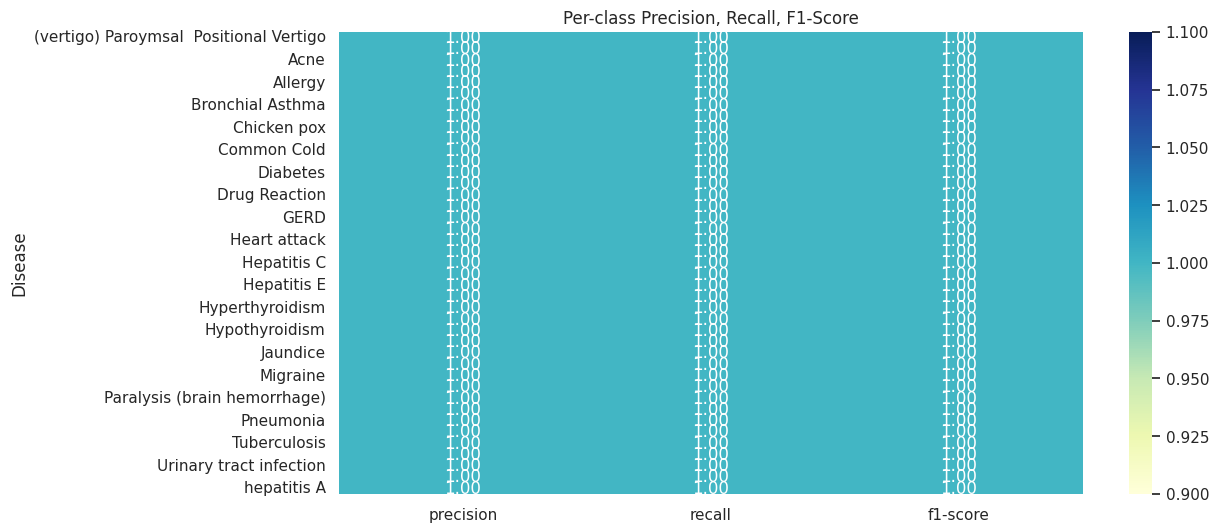

In [57]:
# %%
report = classification_report(y_test_enc, y_test_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Only include actual classes (exclude 'accuracy', 'macro avg', 'weighted avg')
report_df = report_df.iloc[:-3,:]

plt.figure(figsize=(12,6))
sns.heatmap(report_df[['precision','recall','f1-score']], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Per-class Precision, Recall, F1-Score")
plt.ylabel("Disease")
plt.show()


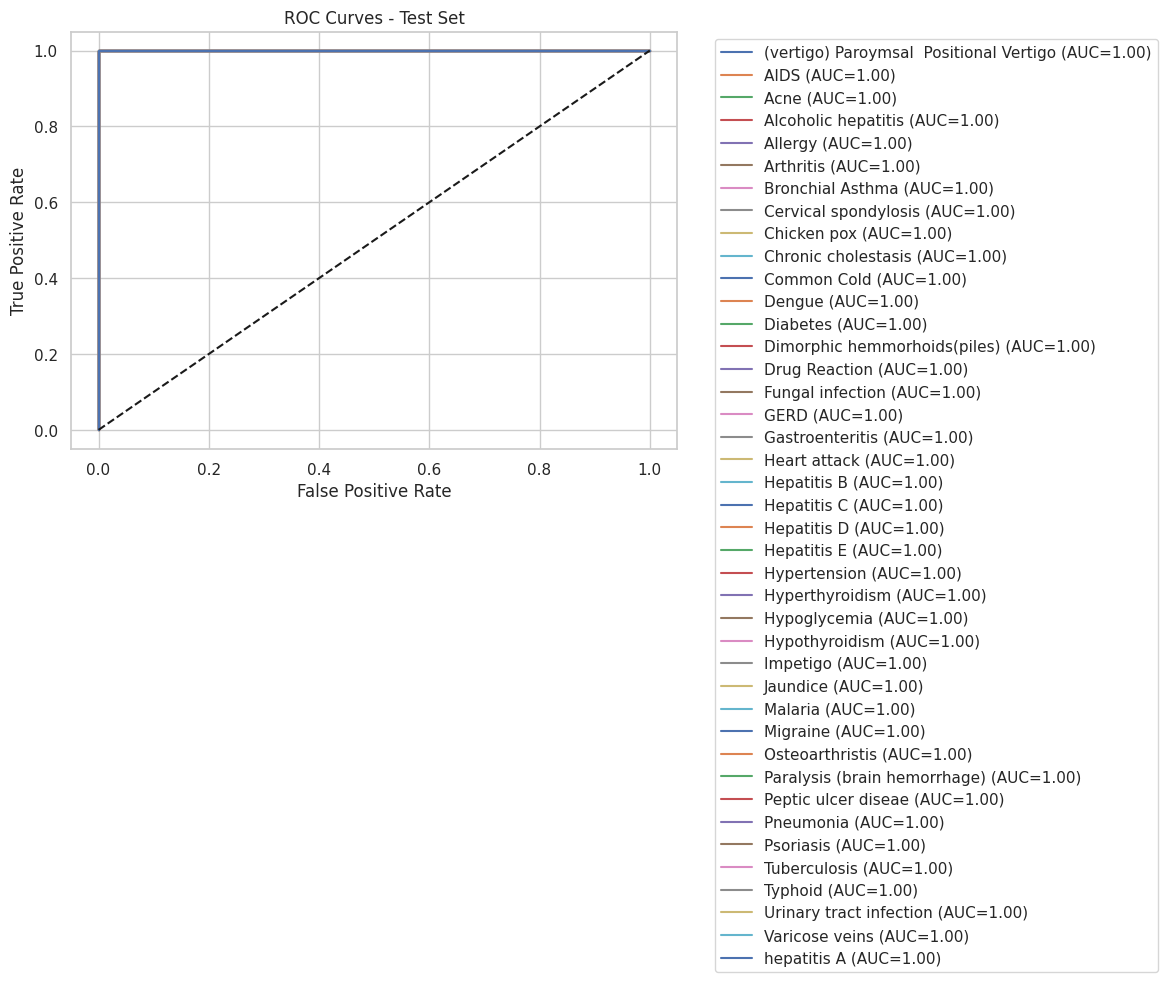

In [58]:
# %%
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels for ROC
y_test_bin = label_binarize(y_test_enc, classes=range(len(le.classes_)))
y_score = model.predict_proba(x_test)

plt.figure(figsize=(12,8))
for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_score[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={roc_auc:.2f})")
    
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Test Set")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipykernel_46627/524397408.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f1_per_class.values, y=f1_per_class.index, palette="viridis")


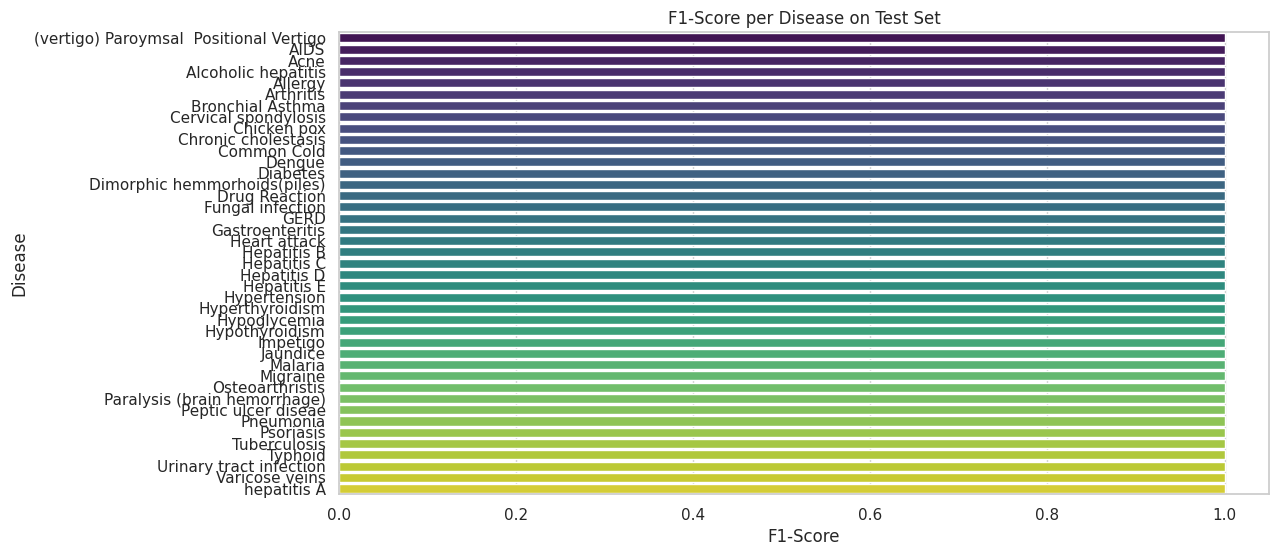

In [59]:
# %%
f1_per_class = report_df['f1-score'].sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=f1_per_class.values, y=f1_per_class.index, palette="viridis")
plt.xlabel("F1-Score")
plt.ylabel("Disease")
plt.title("F1-Score per Disease on Test Set")
plt.show()


In [9]:
# %%
MODEL_PATH = "model_extratrees.pkl"
LE_PATH = "label_encoder.pkl"

with open(MODEL_PATH,"wb") as f:
    pickle.dump(model,f)
with open(LE_PATH,"wb") as f:
    pickle.dump(le,f)
with open(FEATURES_PATH,"wb") as f:
    pickle.dump(MODEL_SYMPTOMS,f)

print("Saved model, encoder, features")


Saved model, encoder, features


In [10]:
# %%
desc = pd.read_csv(SYMPTOM_DESC_PATH)
prec = pd.read_csv(SYMPTOM_PRECAUTION_PATH)

desc['Disease'] = desc['Disease'].astype(str).str.strip()
prec['Disease'] = prec['Disease'].astype(str).str.strip()


In [ ]:
# %%
import os
from ollama import Client
import ast
import pickle
import json
import ast

# Make sure your API key is set in your environment
OLLAMA_API_KEY = "821e286afabb4ab49533fa6c3aeec4c3.Vo7YFxfEOdhfQ16wFpacGEGm"

# Initialize Ollama client
client = Client(
    host="https://ollama.com",
    headers={'Authorization': 'Bearer ' + OLLAMA_API_KEY}
)

def extract_symptoms_from_text(user_text, features_pkl_path="features.pkl", model_name = "gpt-oss:120b"):
    """
    Extract symptoms from free text using Ollama client (online),
    and filter to match the features in features.pkl.
    """
    # Load allowed features
    with open(features_pkl_path,"rb") as f:
        allowed_symptoms = pickle.load(f)

    allowed_json = json.dumps(allowed_symptoms)

    # Build messages for Ollama chat
    messages = [
        {
            'role': 'user',
            'content': f""" You are a strict medical symptom extractor.
        Extract only symptoms mentioned in the user's text and return a Python list.
        Do not include anything not in the allowed list.

        Allowed symptoms (exact strings): {allowed_json}

        User text:
        \"\"\"{user_text}\"\"\"

        Return only a JSON-style Python list (no other text).
        """
        }
    ]

    # try:
    #     # Stream=False for a single complete response
    #     response_parts = client.chat(model_name, messages, stream=False)
    #     raw = response_parts[-1]['message']['content']  # get full response
    # except Exception as e:
    #     print("Ollama client request failed:", e)
    #     raw = "[]"

    # # Parse the output safely
    # try:
    #     res_list = ast.literal_eval(raw.strip())
    # except Exception:
    #     cleaned = raw.replace("```python","").replace("```","").strip()
    #     try:
    #         res_list = ast.literal_eval(cleaned)
    #     except Exception:
    #         # fallback: match words against allowed list
    #         tokens = [t.strip(" .,;:!()[]\"'").lower() for t in raw.split()]
    #         res_list = [s for s in allowed_symptoms if s.lower() in tokens]

    # # Preserve order and filter to allowed features
    # res_filtered = [s for s in allowed_symptoms if s in res_list]

      # safer than eval for parsing strings to Python objects

    output_fragments = []

    # Collect the streamed parts
    for part in client.chat('gpt-oss:120b', messages=messages, stream=True):
        fragment = part['message']['content']
        #print(fragment, end='', flush=True)  # optional: still prints to console
        output_fragments.append(fragment)

    # Join all fragments into a single string
    full_text = ''.join(output_fragments)

    # Convert the string representation of a list into an actual Python list
    try:
        output_list = ast.literal_eval(full_text)
    except Exception as e:
        print("Failed to parse output as list:", e)
        output_list = []

    print(output_list)

# Now the variable `output_list` contains all the streamed parts

    return output_list


In [12]:
# %%
def symptoms_to_vector(symptom_list, features_pkl_path=FEATURES_PATH):
    with open(features_pkl_path,"rb") as f:
        feature_list = pickle.load(f)
    vec = np.zeros((1, len(feature_list)), dtype=np.int8)
    feat_map = {f:i for i,f in enumerate(feature_list)}
    for s in symptom_list:
        if s in feat_map:
            vec[0, feat_map[s]] = 1
    return vec


In [ ]:
# %%
def predict_from_symptom_list(symptom_list, model, le, feature_list, top_k=5):
    X = symptoms_to_vector(symptom_list)
    proba = model.predict_proba(X)[0]
    idx = np.argsort(proba)[-top_k:][::-1]
    results = []
    for i in idx:
        results.append({"disease": le.classes_[i], "probability": float(proba[i])})
    return results

def display_prediction_details(results,location):
    for r in results:
        disease = r['disease']
        p = r['probability']
        print(f"\nDisease: {disease}  —  Prob: {p:.4f}")
        if disease in desc['Disease'].values:
            text = desc.loc[desc['Disease']==disease].values[0][1]
            print("Description:", text)
        if disease in prec['Disease'].values:
            row = prec.loc[prec['Disease']==disease].values[0][1:]
            print("Precautions:")
            for item in row:
                if pd.notna(item) and str(item).strip():
                    print("-", item)



In [60]:
symptoms = ["high fever","chills","sweating","headache","nausea"]
results = predict_from_symptom_list(symptoms, model, le, MODEL_SYMPTOMS)
display_prediction_details(results)



Disease: Malaria  —  Prob: 0.2367
Description: An infectious disease caused by protozoan parasites from the Plasmodium family that can be transmitted by the bite of the Anopheles mosquito or by a contaminated needle or transfusion. Falciparum malaria is the most deadly type.
Precautions:
- Consult nearest hospital
- avoid oily food
- avoid non veg food
- keep mosquitos out

Disease: Typhoid  —  Prob: 0.1800
Description: An acute illness characterized by fever caused by infection with the bacterium Salmonella typhi. Typhoid fever has an insidious onset, with fever, headache, constipation, malaise, chills, and muscle pain. Diarrhea is uncommon, and vomiting is not usually severe.
Precautions:
- eat high calorie vegitables
- antiboitic therapy
- consult doctor
- medication

Disease: Allergy  —  Prob: 0.1100
Description: An allergy is an immune system response to a foreign substance that's not typically harmful to your body.They can include certain foods, pollen, or pet dander. Your immun

In [62]:
# %%
user_text = "I feel my body burning one moment and shaking the next, my head pounding, my muscles aching, and my stomach unsettled. Every few hours, I sweat until I’m drenched, only to feel weak and dizzy, trapped in a relentless cycle of fever and chills."
extracted_symptoms = extract_symptoms_from_text(user_text)
print("Extracted symptoms:", extracted_symptoms)

results = predict_from_symptom_list(extracted_symptoms, model, le, MODEL_SYMPTOMS)
display_prediction_details(results)


["chills"]['chills']
Extracted symptoms: ['chills']

Disease: Allergy  —  Prob: 0.4300
Description: An allergy is an immune system response to a foreign substance that's not typically harmful to your body.They can include certain foods, pollen, or pet dander. Your immune system's job is to keep you healthy by fighting harmful pathogens.
Precautions:
- apply calamine
- cover area with bandage
- use ice to compress itching

Disease: Urinary tract infection  —  Prob: 0.0933
Description: Urinary tract infection: An infection of the kidney, ureter, bladder, or urethra. Abbreviated UTI. Not everyone with a UTI has symptoms, but common symptoms include a frequent urge to urinate and pain or burning when urinating.
Precautions:
- drink plenty of water
- increase vitamin c intake
- drink cranberry juice
- take probiotics

Disease: Arthritis  —  Prob: 0.0633
Description: Arthritis is the swelling and tenderness of one or more of your joints. The main symptoms of arthritis are joint pain and stif

ERROR: Could not find a version that satisfies the requirement azure-synapse-sql (from versions: none)
ERROR: No matching distribution found for azure-synapse-sql


In [14]:
import pyodbc
import pandas as pd

# Connection details
server = 'cityhealthcare123workspace.sql.azuresynapse.net'
database = 'new City Health Pool'
username = 'sqladminuser'
password = 'City123#'
driver = '{ODBC Driver 18 for SQL Server}'  # Make sure you have it installed

# Connect to Synapse
conn = pyodbc.connect(
    f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'
)

# Query data
df_patients = pd.read_sql("SELECT * FROM dbo.Patients", conn)
print(df_patients.head())  # Show first rows

# Close connection
conn.close()


/tmp/ipykernel_33246/794774397.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_patients = pd.read_sql("SELECT * FROM dbo.Patients", conn)


   patient_id     national_id first_name  last_name date_of_birth  gender  \
0        4715  25010258756884      Samar  Abdelaziz    1950-10-25  Female   
1          49  30608026010095       Adel     Mohsen    2006-08-02    Male   
2        6266  29308041017389      Layan      Helmy    1993-08-04  Female   
3          50  26107123817983      Hagar   Abdullah    1961-07-12  Female   
4           6  27109206004502       Nora      Zayed    1971-09-20  Female   

        phone                                    address blood_type  \
0  0109217998    2147 El Horreya Lane, Hurghada, Red Sea         A+   
1  0152342729        6097 Salah Salem Ave., Fayed, Sohag         B+   
2  0154123359    6923 El Mostaqbal Lane, Zagazig, Faiyum         B+   
3  0154782932  237 El Gomhouria Ave., Zifta, North Sinai         O+   
4  0157002730     5466 El Tahrir Sq., Mansoura, Dakahlia        AB+   

            allergies   chronic_diseases emergency_contact_name  \
0                None          Arthritis   

In [ ]:
import pyodbc
import pandas as pd

# -----------------------------
# Connection details
# -----------------------------
server = 'cityhealthcare123workspace.sql.azuresynapse.net'
database = 'new City Health Pool'
username = 'sqladminuser'
password = 'City123#'
driver = '{ODBC Driver 18 for SQL Server}'  # Ensure installed

# Connect to Synapse
conn = pyodbc.connect(
    f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;'
)

# -----------------------------
# User inputs
# -----------------------------
disease_input = input("Enter disease: ").strip()
location_input = input("Enter location: ").strip()

# -----------------------------
# Step 1: Get speciality for the disease
# -----------------------------
query_speciality = "SELECT speciality FROM healthcare.Disease_Speiality WHERE disease = ?"
speciality_df = pd.read_sql(query_speciality, conn, params=[disease_input])

if speciality_df.empty:
    print("No speciality found for this disease.")
else:
    speciality = speciality_df.iloc[0]['speciality']
    print(f"Speciality for {disease_input}: {speciality}")

    # -----------------------------
    # Step 2: Get doctors with that speciality
    # -----------------------------
    query_doctors = """
    SELECT 
        CONCAT(first_name, ' ', last_name) AS doctor_name,
        phone_number,
        service_provider
    FROM dbo.Doctors
    WHERE speciality = ?
    """
    doctors_df = pd.read_sql(query_doctors, conn, params=[speciality])

    if doctors_df.empty:
        print("No doctors found for this speciality.")
    else:
        # -----------------------------
        # Step 3: Get service providers in the requested location
        # -----------------------------
        service_providers = doctors_df['service_provider'].unique().tolist()
        query_providers = f"""
        SELECT service_provider, address
        FROM dbo.Service_Providers
        WHERE service_provider IN ({','.join(['?']*len(service_providers))})
          AND location = ?
        """
        providers_df = pd.read_sql(query_providers, conn, params=service_providers + [location_input])

        if providers_df.empty:
            print("No service providers found in this location.")
        else:
            # -----------------------------
            # Step 4: Merge doctor info with provider info
            # -----------------------------
            final_df = doctors_df.merge(providers_df, on='service_provider', how='inner')
            print(final_df)

# Close connection
conn.close()


/tmp/ipykernel_33246/307562148.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  speciality_df = pd.read_sql(query_speciality, conn, params=[disease_input])


DatabaseError: Execution failed on sql: 
SELECT speciality 
FROM dbo.disease_speiality
WHERE disease = ?

('42S02', "[42S02] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]Invalid object name 'dbo.disease_speiality'. (208) (SQLExecDirectW)")
unable to rollback

In [2]:
import pandas as pd
from sqlalchemy import create_engine

# SQLAlchemy engine بدل pyodbc مباشر
server = 'cityhealthcare123workspace.sql.azuresynapse.net'
database = 'new City Health Pool'
username = 'sqladminuser'
password = 'City123#'
driver = 'ODBC Driver 17 for SQL Server'

# الاتصال بالـ Synapse
engine = create_engine(f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}')

# جلب أفضل نسخة من كل جدول
df_patients = pd.read_sql("SELECT * FROM dbo.Patients", engine)
df_appointments = pd.read_sql("SELECT * FROM dbo.Appointments", engine)
df_medications = pd.read_sql("SELECT * FROM dbo.Medications", engine)
df_medical_readings = pd.read_sql("SELECT * FROM dbo.Medical_Readings", engine)
df_doctors = pd.read_sql("SELECT * FROM dbo.Doctors", engine)
df_system_alerts = pd.read_sql("SELECT * FROM dbo.System_Alerts", engine)
df_service_providers = pd.read_sql("SELECT * FROM dbo.Service_Providers", engine)

DBAPIError: (pyodbc.Error) ('01000', "[01000] [unixODBC][Driver Manager]Can't open lib 'ODBC Driver 17 for SQL Server' : file not found (0) (SQLDriverConnect)")
(Background on this error at: https://sqlalche.me/e/20/dbapi)